# Using JWST Guide Star Data Products
## Introduction

<a id="Introduction"></a>

Thus notebook provides and demonstrates code for retrieving and plotting JWST guiding data products. These provide a record of the line-of-sight guiding during science observations. If you want to check on the guiding performance during some particular science observations, this is one way to do that. 


The guide star files may be retrieved from MAST via the <a href="https://astroquery.readthedocs.io/en/latest/mast/mast.html">astroquery.mast</a> interface. This does so, then generates some potentially-informative plots.

Credit to Dick Shaw and Rick White of the STScI Archive Sciences Branch team for guidance in implementing the MAST query portion of this.

In [108]:
import os, sys
import requests
from astroquery.mast import Mast,Observations
from astropy.table import Table, unique, vstack
import astropy.time
import astropy.io.fits as fits
import numpy as np

import matplotlib.pyplot as plt

### Search for Guide Star Data


In [22]:
filename = '/Users/mperrin/Downloads/jw02725387001_03105_00001_nrca3_rate.fits'

In [158]:
def mast_retrieve_guiding_files(filenames, out_dir='.'):
    """Download one or more guiding data products from MAST
    
    If the file is already present in the specified local directory, it's not downloaded again. 
    
    """
    
    mast_url='https://mast.stsci.edu/api/v0.1/Download/file'
    uri_prefix = 'mast:JWST/product/'
    
    outputs = []
    
    for p in filenames:
        outfile = os.path.join(out_dir, p)

        if os.path.isfile(outfile):
            print("ALREADY DOWNLOADED: ", outfile)
            outputs.append(outfile)
            continue

        r = requests.get(mast_url, params=dict(uri=uri_prefix+p), stream=True
                    # include the following argument if authentication is needed
                    #headers=dict(Authorization=f"token {mast_api_token}"))
                        )
        r.raise_for_status()
        with open(outfile, 'wb') as fd:
            for data in r.iter_content(chunk_size=1024000):
                fd.write(data)

        if not os.path.isfile(outfile):
            print("ERROR: " + outfile + " failed to download.")
        else:
            print("COMPLETE: ", outfile)
            outputs.append(outfile)
    return outputs

def set_params(parameters):
    """Utility function for making dicts used in MAST queries"""
    return [{"paramName":p, "values":v} for p,v in parameters.items()]


def find_relevant_guiding_file(sci_filename, verbose=True):
    """ Given a filename of a JWST science file, retrieve the relevant guiding data product. 
    This uses FITS keywords in the science header to determine the time period and guide mode,
    and then retrieves the file from MAST
    
    """
    
    
    sci_hdul = fits.open(sci_filename)
    
    progid = sci_hdul[0].header['PROGRAM']
    obs = sci_hdul[0].header['OBSERVTN']
    guidemode = sci_hdul[0].header['PCS_MODE']
    
    
    # Set up the query
    keywords = {
    'program': [progid]
    ,'observtn': [obs]
    ,'exp_type': ['FGS_'+guidemode]
    }

    params = {
        'columns': '*',
        'filters': set_params(keywords)
        }


    # Run the web service query. This uses the specialized, lower-level webservice for the
    # guidestar queries: https://mast.stsci.edu/api/v0/_services.html#MastScienceInstrumentKeywordsGuideStar

    service = 'Mast.Jwst.Filtered.GuideStar'
    t = Mast.service_request(service, params)


    if len(t) > 0:
        # Ensure unique file names, should any be repeated over multiple observations (e.g. if parallels):
        fn = list(set(t['fileName']))
        # Set of derived Observation IDs:

        products = list(set(fn))
        # If you want the uncals instead do this:
        #products = list(set([x.replace('_cal','_uncal') for x in fn]))
    products.sort()

        
    if verbose:
        print(f"For science data file: {sci_filename}")
        print("Found guiding telemetry files:")
        for p in products:
            print("   ", p)
            
    guide_timestamps = np.asarray([fn.split('_')[2] for fn in products], int)
    t_beg = astropy.time.Time(sci_hdul[0].header['DATE-BEG'])
    t_end = astropy.time.Time(sci_hdul[0].header['DATE-END'])
    
    wmatch = np.argmin(np.abs(guide_timestamps-obs_end_time))

    print("Based on science DATE-END keyword and guiding timestamps, the matching GS file is: ")
    print("   ", products[wmatch])  
    
    products_to_fetch = [products[wmatch],]
    
    outfiles = mast_retrieve_guiding_files(products_to_fetch)
    
    return outfiles

## Guiding Performance Plot

In [180]:
def guiding_performance_plot(sci_filename, verbose=True, save=False):
    """Generate a plot showing the guiding jitter during an exposure
    
    
    """
    
    # Retrieve the guiding packet file from MAST
    gs_fns = find_relevant_guiding_file(sci_filename)

    gs_fn = gs_fns[0]
    gs_fn_base = os.path.splitext(os.path.basename(gs_fn))[0]

    
    
    with fits.open(sci_filename) as sci_hdul:
        t_beg = astropy.time.Time(sci_hdul[0].header['DATE-BEG'])
        t_end = astropy.time.Time(sci_hdul[0].header['DATE-END'])


    # Read the data from that file, and parse into astropy Times

    pointing_table = astropy.table.Table.read(gs_fn, hdu=4) #, extname='POINTING') #, ext=4)
    centroid_table = astropy.table.Table.read(gs_fn, hdu=5) #, extname='POINTING') #, ext=4)

    mask = centroid_table.columns['bad_centroid_dq_flag'] == 'GOOD'

    ctimes = astropy.time.Time(centroid_table['observatory_time'])
    ptimes = astropy.time.Time(pointing_table.columns['time'], format='mjd')

    # Compute the mean X and Y positions
    xmean = centroid_table[mask]['guide_star_position_x'].mean()
    ymean = centroid_table[mask]['guide_star_position_y'].mean()

    
    # Create Plots
    fig, axes = plt.subplots(figsize=(16,12), nrows=3)
    
    min_time = np.min([ptimes.plot_date.min(), ctimes.plot_date.min()])
    max_time = np.max([ptimes.plot_date.max(), ctimes.plot_date.max()])
    dtime = max_time - min_time
    
    for i in range(3):
        axes[i].xaxis.axis_date()
        axes[i].set_xlim(min_time -0.01*dtime, max_time+0.01*dtime)

    axes[0].set_title(f"Guiding during {os.path.basename(sci_filename)}", fontweight='bold', fontsize=18)    
        
    axes[0].semilogy(ptimes.plot_date, pointing_table.columns['jitter'], alpha=1, color='C0')
    axes[0].set_ylim(1e-2, 1e3)
    axes[0].set_ylabel("Jitter\n[mas]", fontsize=18)
    axes[0].text(0.01, 0.95, os.path.basename(gs_fn), fontsize=16, transform=axes[0].transAxes, verticalalignment='top')

    axes[0].axvspan(t_beg.plot_date, t_end.plot_date, color='green', alpha=0.15)
    axes[0].text(t_beg.plot_date, 50, " Exposure", color='green')
    axes[0].text(ptimes.plot_date.min(), 100, " Guiding Start", color='C0')
    axes[0].text(ptimes.plot_date.max(), 100, "Guiding End ", color='C0',
                horizontalalignment='right')


    axes[1].plot(ctimes[mask].plot_date, centroid_table[mask]['guide_star_position_x']-xmean, label='X Centroids', color='C1')
    axes[1].plot(ctimes[mask].plot_date, centroid_table[mask]['guide_star_position_y']-ymean, label='Y Centroids', color='C4')
    axes[1].legend()
    axes[1].axvspan(t_beg.plot_date, t_end.plot_date, color='green', alpha=0.15)
    axes[1].set_ylabel("GS centroid offsets\n[pixels]", fontsize=18)
    axes[1].axhline(0, ls=":", color='gray')

    axes[2].plot(ctimes.plot_date, mask, label='GOOD Centroids', color='C1')

    axes[2].axvspan(t_beg.plot_date, t_end.plot_date, color='green', alpha=0.15)
    axes[2].set_ylabel("Centroid Quality Flag\n", fontsize=18)
    axes[2].set_yticks((0,1))
    axes[2].set_ylim(-0.5, 1.5)
    axes[2].set_yticklabels(['BAD', 'GOOD'])


    outname = f'guidingplot_{gs_fn_base}.pdf'

    if save: 
        plt.savefig(outname)
        if verbose:
            print(f' ==> {outname}')

For science data file: /Users/mperrin/Downloads/jw02725387001_03105_00001_nrca3_rate.fits
Found guiding telemetry files:
    jw02725387001_gs-fg_2022207164836_cal.fits
    jw02725387001_gs-fg_2022207165907_cal.fits
    jw02725387001_gs-fg_2022207170616_cal.fits
    jw02725387001_gs-fg_2022207170944_cal.fits
Based on science DATE-END keyword and guiding timestamps, the matching GS file is: 
    jw02725387001_gs-fg_2022207170616_cal.fits
ALREADY DOWNLOADED:  ./jw02725387001_gs-fg_2022207170616_cal.fits


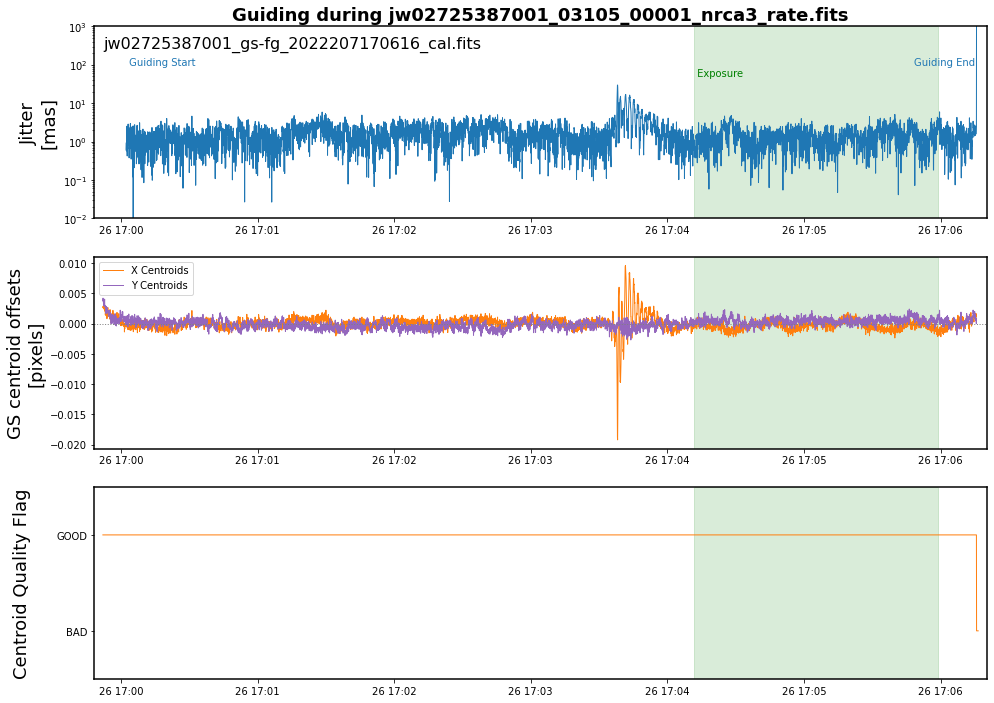

In [181]:
guiding_performance_plot(filename)

For science data file: /Users/mperrin/Downloads/jw01163062001_02102_00001_nrca3_rate.fits
Found guiding telemetry files:
    jw01163062001_gs-fg_2022152165255_cal.fits
    jw01163062001_gs-fg_2022152170612_cal.fits
    jw01163062001_gs-fg_2022152171822_cal.fits
    jw01163062001_gs-fg_2022152172422_cal.fits
Based on science DATE-END keyword and guiding timestamps, the matching GS file is: 
    jw01163062001_gs-fg_2022152172422_cal.fits
ALREADY DOWNLOADED:  ./jw01163062001_gs-fg_2022152172422_cal.fits


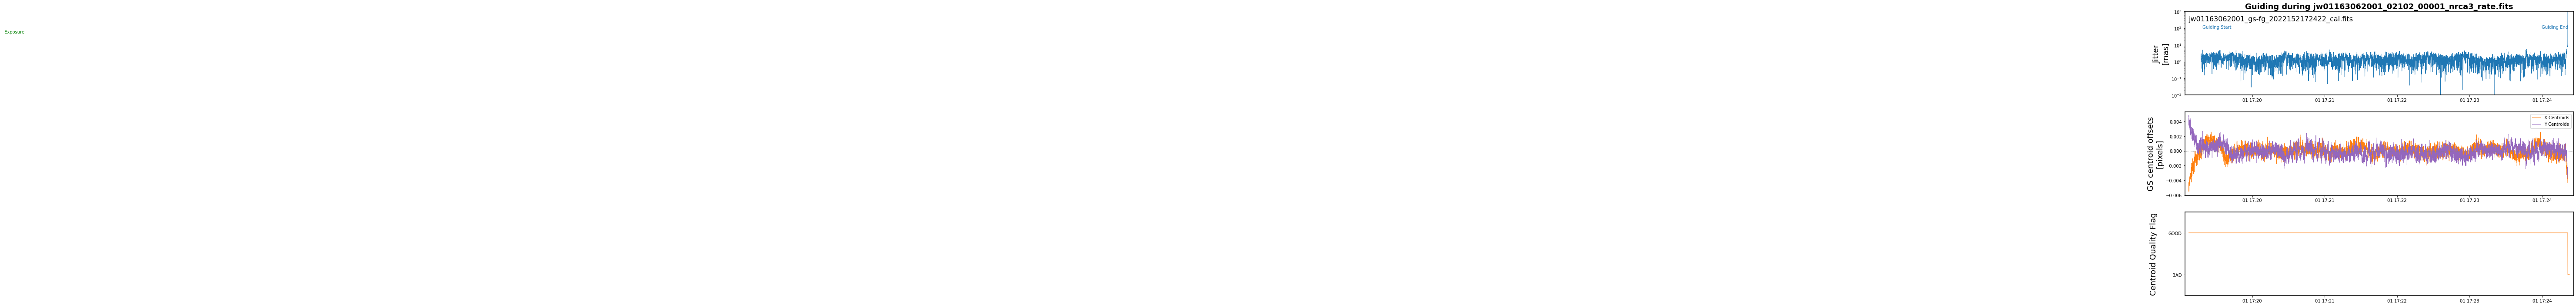

In [182]:
guiding_performance_plot('/Users/mperrin/Downloads/jw01163062001_02102_00001_nrca3_rate.fits')

For science data file: /Users/mperrin/Downloads/jw01442003001_02102_00001_nrca3_cal.fits
Found guiding telemetry files:
    jw01442003001_gs-fg_2022122130431_cal.fits
Based on science DATE-END keyword and guiding timestamps, the matching GS file is: 
    jw01442003001_gs-fg_2022122130431_cal.fits
ALREADY DOWNLOADED:  ./jw01442003001_gs-fg_2022122130431_cal.fits


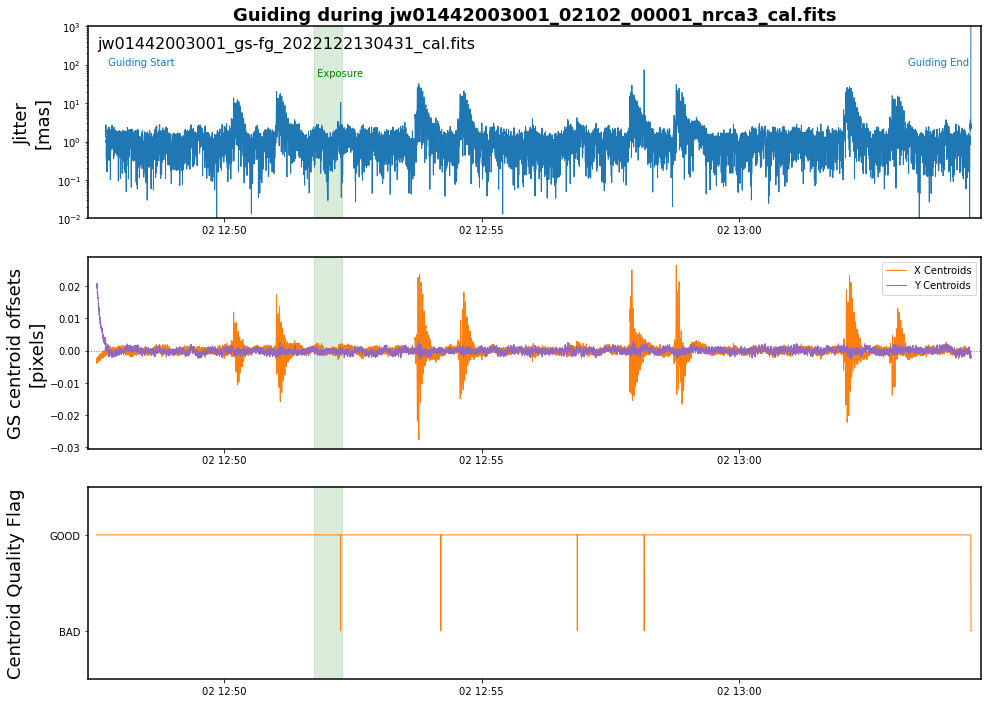

In [183]:
guiding_performance_plot('/Users/mperrin/Downloads/jw01442003001_02102_00001_nrca3_cal.fits')

For science data file: /Users/mperrin/Downloads/jw01163-o055_t002_nircam_f212n-wlp8-nrca3_wfscmb-05.fits
Found guiding telemetry files:
    jw01163055001_gs-fg_2022140092328_cal.fits
    jw01163055001_gs-fg_2022140093549_cal.fits
    jw01163055001_gs-fg_2022140094148_cal.fits
Based on science DATE-END keyword and guiding timestamps, the matching GS file is: 
    jw01163055001_gs-fg_2022140094148_cal.fits
ALREADY DOWNLOADED:  ./jw01163055001_gs-fg_2022140094148_cal.fits


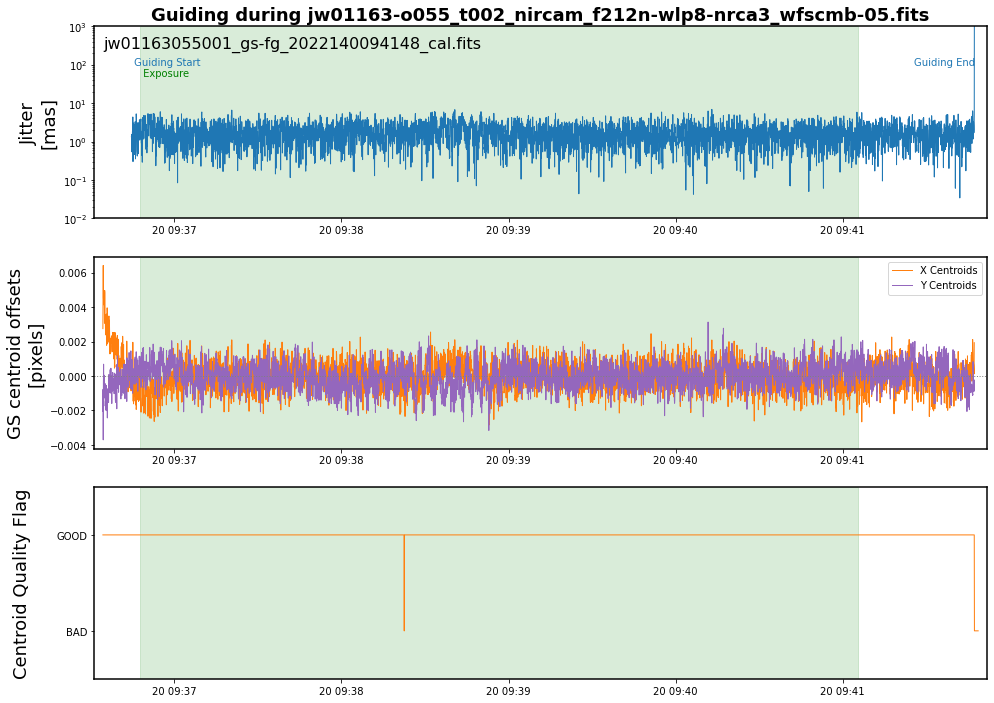

In [184]:
guiding_performance_plot('/Users/mperrin/Downloads/jw01163-o055_t002_nircam_f212n-wlp8-nrca3_wfscmb-05.fits')

In [185]:
!ls

JWST_GS_02725_387
JWST_Obs_by_SI_KW_from_file.ipynb
JWST_Obs_by_SI_KW_mp.ipynb
guidingplot_jw01245034001_gs-track_2022270002929_cal.png
guidingplot_jw02725387001_gs-fg_2022207170616_cal.pdf
jw01163055001_gs-fg_2022140094148_cal.fits
jw01163062001_gs-fg_2022152172422_cal.fits
jw01442003001_gs-fg_2022122130431_cal.fits
jw02725387001_gs-fg_2022207170616_cal.fits


## About this notebook

Based in part on a notebook developed by Archive Sciences Branch staff, chiefly Dick Shaw and Rick White. For support, please contact the Archive HelpDesk at archive@stsci.edu, or through the [JWST HelpDesk Portal](https://jwsthelp.stsci.edu). 
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>